# Progetto di Classificazione di Forme Geometriche da Sequenze di Punti

## Obiettivo del progetto

Lo scopo di questo progetto è sviluppare un sistema automatico in grado di riconoscere forme geometriche semplici - ellissi, rettangoli, segmenti e coppie di segmenti che si incrociano in modo ortogonale, a croce - a partire da sequenze di punti che ne rappresentano il contorno.

## Dataset
Il dataset viene calcolato in modo sintetico per mezzo della funzione _genera_campioni_, che determina una sequenza di punti per ogni forma, aggiungendo un eventuale rumore gaussiano.
Si consideri inizialmente un dataset composto da **4000 forme** (1000 per tipo) ognuna descritta da 100 punti, ordinati secondo l'ordine di generazione dell'algoritmo utilizzato, con associato il relativo target, sotto forma di un intero tra 0 e 3, associato a una label per la forma dalla lista labels. 


200 valori rappresenta un campione etichettato costituito da una sequenza di numeri in vergola mobile $x_1\ y_1\ x_2\ y_2\ \ldots x_{100}\ y_{100}$ che rappresentano le $200$ coordinate dei $100$  punti che descrivono il perimetro della forma, seguita da una etichetta testuale (ellisse, rettangolo, segmento, croce) che indica la forma rappresentata.

## Compiti dello studente

Lo studente dovrà progettare un **classificatore automatico** in grado di riconoscere correttamente la forma rappresentata da ciascuna sequenza. Il progetto richiede di affrontare i seguenti step:

### 1. Rappresentazione e feature engineering
Definire una rappresentazione vettoriale delle forme implementando la funzione _ottieni_features_. Nel codice, viene fornita una implementazione di tale funzione corrispondente ad una banale rappresentazione in cui l'insieme di punti $(x_1,y_1), \ldots, (x_n, y_n)$ è rappresentato da un vettore $x_1,y_1, \ldots,x_n, y_n$. Si valuti l'utilizzo di rappresetazioni diverse sia utilizzando metodi algoritmici (feature selection, feature extraction) che definendo nuove features (es. distanza dal centroide, perimetro e distanza tra punti estremi, etc.).

### 2. Costruzione e valutazione di classificatori

- Utilizzare le caratteristiche estratte per addestrare e confrontare un insieme di classificatori, valutando anche il valore ottimo (o sufficientemente buono) di iperparametri definiti per il classificatore considerato (model selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, derivato dal dataset calcolato mediante splitting o anche prodotto utilizzando il medesimo algoritmo.
- Esaminare e confrontare le prestazioni ottenute sul training e sul test set e controllare l'eventaule overfitting

### 3. Test di robustezza
Analizzare l'effetto sulle prestazioni ottenute dai vari modelli, e su quelle del miglior classificatore di
- Quantità di forme disponibili come esempio
- Numero di punti che descrivono la singola forma
- Quantità di rumore gaussiano
Analizzare inoltre la differenza di prestazioni al variare del dataset considerato, prodotto comunque secondo il medesimo algoritmo.

### 4. Classificazione binaria
Considerare il problema di classificazione binaria derivato considerando la classe delle forme con area nulla (segmento, croce) vs. la classe di quelle ad area positiva (ellisse, rettangolo), unendo quindi da un lato le classi 0 e 1 e dall'altro le classi 2,3. Analizzare le prestazioni ottenute sul problema secondo le indicazioni precedenti.

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import ConvexHull, QhullError
from scipy.spatial.distance import pdist
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SelectFromModel

In [215]:
def to_stringa(punti, forma):
    return ";".join(f"{x:.3f}:{y:.3f}" for x, y in punti)+','+forma

def print_forma(n, X, y, labels):
    for x_i, y_i in zip(X[:n], y[:n]):
        print(to_stringa(x_i, labels[y_i]))
        
def plot_shape(X, y, labels):
    """
    Mostra una shape rappresentativa per ciascuna classe presente in y.

    Args:
        X (list of np.ndarray): lista di array (uno per forma) di shape (n_punti, 2)
        y (np.ndarray): array di interi con le etichette corrispondenti alle forme
        labels (list of str): nomi delle etichette per le forme
    """
    classi = np.unique(y)
    num_classi = len(classi)

    fig, axs = plt.subplots(1, num_classi, figsize=(4 * num_classi, 4))

    if num_classi == 1:
        axs = [axs]  # Assicura che axs sia sempre iterabile
    
    for i, etichetta in enumerate(classi):
        idx = np.where(y == etichetta)[0][0]  # Primo esempio con quell'etichetta
        shape = X[idx]
        ax = axs[i]

        ax.plot(shape[:, 0], shape[:, 1], color='C' + str(etichetta))
        ax.set_title(f"Classe {etichetta}: {labels[etichetta].capitalize()}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.axis("equal")
        ax.grid(True)

    plt.tight_layout()
    plt.suptitle("Una forma per ciascuna classe", fontsize=16, y=1.05)
    plt.show()



def genera_segmento(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera un segmento rettilineo con n_punti, tra due estremi calcolati a partire da un punto centrale (x0, y0),
    una lunghezza totale l e un angolo theta rispetto all'asse x. I punti sono distribuiti uniformemente lungo il segmento,
    con l'aggiunta opzionale di rumore gaussiano.

    Args:odel selection), utilizzano un validation set o la cross-validation
- Valutare le prestazioni dei vari modelli su un test set anch'esso sintetico, 
        x0 (float): coordinata x del punto centrale del segmento
        y0 (float): coordinata y del punto centrale del segmento
        theta (float): angolo del segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza del segmento (il segmento totale sarà lungo 2*l)
        n_punti (int): numero di punti da generare lungo il segmento
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Calcola le coordinate dei due estremi del segmento
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    # Interpolazione lineare tra i due estremi per ottenere i punti
    t = np.linspace(0, 1, n_punti) # n valori tra 0 - 1
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    # Aggiunta di rumore gaussiano alle coordinate
    x += np.random.normal(0, rumore_std, size=n_punti)
    y += np.random.normal(0, rumore_std, size=n_punti)
    # Restituisce un array Nx2 con i punti generati
    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)

def genera_croce(x0, y0, theta, l, n_punti=50, rumore_std = 0.01):
    """
    Genera una croce composta da due segmenti ortogonali che si intersecano nel punto (x0, y0).
    Ogni segmento è centrato in (x0, y0), ha lunghezza totale 2*l e angolo theta (il secondo segmento è ruotato di 90° rispetto al primo).
    I punti sono distribuiti uniformemente lungo i segmenti, con aggiunta opzionale di rumore gaussiano.

    Args:
        x0 (float): coordinata x del centro della croce
        y0 (float): coordinata y del centro della croce
        theta (float): angolo del primo segmento rispetto all'asse x (in radianti)
        l (float): metà lunghezza di ciascun segmento (ogni segmento è lungo 2*l)
        n_punti (int): numero totale di punti da generare (divisi equamente tra i due segmenti)
        rumore_std (float): deviazione standard del rumore gaussiano da aggiungere ai punti

    Returns:
        np.ndarray: array di shape (n_punti, 2) contenente le coordinate dei punti generati
    """
    # Primo segmento (angolo theta)
    x1 = x0 + l * np.cos(theta)
    y1 = y0 + l * np.sin(theta)
    x2 = x0 - l * np.cos(theta)
    y2 = y0 - l * np.sin(theta)
    t = np.linspace(0, 1, n_punti//2)
    x = x1 + t * (x2 - x1)
    y = y1 + t * (y2 - y1)
    x += np.random.normal(0, rumore_std, size=n_punti//2)
    y += np.random.normal(0, rumore_std, size=n_punti//2)

    # Secondo segmento (angolo theta + 90°)
    x1 = x0 - l * np.sin(theta)
    y1 = y0 + l * np.cos(theta)
    x2 = x0 + l * np.sin(theta)
    y2 = y0 - l * np.cos(theta)
    t = np.linspace(0, 1, n_punti//2)
    xx = x1 + t * (x2 - x1)
    yy = y1 + t * (y2 - y1)
    xx += np.random.normal(0, rumore_std, size=n_punti//2)
    yy += np.random.normal(0, rumore_std, size=n_punti//2)

    # Unisce i punti dei due segmenti
    x = np.concatenate([x, xx])
    y = np.concatenate([y, yy])

    return np.stack([x, y], axis=1)  # shape: (n_punti, 2)



def genera_ellisse(a=1.0, b=0.5, centro=(0, 0), angolo=0.0, n_punti=100, rumore_std=0.0):
    """
    Genera punti su un'ellisse centrata in `centro`, con semiassi `a` e `b`,
    ruotata di `angolo` radianti, e opzionalmente con rumore gaussiano.

    Parametri:
    - a (float): semiasse maggiore
    - b (float): semiasse minore
    - centro (tuple): coordinate del centro (x0, y0)
    - angolo (float): rotazione in radianti (es. np.pi/4 per 45°)
    - n_punti (int): numero di punti da generare
    - rumore_std (float): deviazione standard del rumore gaussiano da aggiungere

    Ritorna:
    - array Nx2 con i punti [x, y]
    """
    
    t = np.linspace(0, 2 * np.pi, n_punti)
    x = a * np.cos(t)
    y = b * np.sin(t)

    # Rotazione
    x_rot = x * np.cos(angolo) - y * np.sin(angolo)
    y_rot = x * np.sin(angolo) + y * np.cos(angolo)

    # Traslazione
    x_finale = x_rot + centro[0]
    y_finale = y_rot + centro[1]

    # Rumore
    x_finale += np.random.normal(0, rumore_std, size=n_punti)
    y_finale += np.random.normal(0, rumore_std, size=n_punti)

    return np.stack([x_finale, y_finale], axis=1)


def genera_rettangolo(larghezza=1.0, altezza=0.5, centro=(0, 0), angolo=0.0,
            rumore_std=0.0, n_punti=100):
    """
    Genera punti distribuiti lungo i 4 lati di un rettangolo ruotato e centrato,
    in modo proporzionale alla lunghezza dei lati.

    Args:
        larghezza (float): larghezza del rettangolo
        altezza (float): altezza del rettangolo
        centro (tuple): centro (x, y)
        angolo (float): rotazione in radianti
        rumore_std (float): rumore gaussiano (std dev)
        n_punti (int): numero totale di punti da generare

    Returns:
        np.ndarray: array (n_punti, 2) con i punti lungo i lati
    """
    if n_punti < 4:
        raise ValueError("n_punti deve essere almeno 4")

    # Vertici base
    w, h = larghezza / 2, altezza / 2
    vertici = np.array([
        [-w, -h],
        [ w, -h],
        [ w,  h],
        [-w,  h]
    ])

    # Lati e lunghezze
    lati = [(vertici[(i+1) % 4] - vertici[i]) for i in range(4)]
    lunghezze = np.array([np.linalg.norm(l) for l in lati])
    proporzioni = lunghezze / lunghezze.sum()

    # Distribuzione dei punti
    n_per_lato = np.floor(proporzioni * n_punti).astype(int)
    restante = n_punti - n_per_lato.sum()
    for i in range(restante):
        n_per_lato[i % 4] += 1

    # Generazione dei punti
    punti = []
    for i, n in enumerate(n_per_lato):
        start = vertici[i]
        end = vertici[(i + 1) % 4]
        t_values = np.linspace(0, 1, n, endpoint=False)
        lato = np.outer(1 - t_values, start) + np.outer(t_values, end)
        punti.append(lato)
    punti = np.vstack(punti)

    # Rotazione, traslazione e rumore
    R = np.array([
        [np.cos(angolo), -np.sin(angolo)],
        [np.sin(angolo),  np.cos(angolo)]
    ])
    punti = punti @ R.T
    punti += np.array(centro)
    punti += np.random.normal(0, rumore_std, punti.shape)

    return punti

## Calcolo di ulteriori features

1. **Distanze dal Centroide, media, varianza, massima e minima distanza**

Il centroide è il *centro geometrico* di una figura o di un insieme di punti. Corrisponde al punto che lo bilancia perfettamente, come se fosse il baricentro. Nel caso in cui la figura è rappresentata mediante un insieme di punti nello spazione 2D, ovvero $(x_1, y_1) \dots (x_n, y_n)$, il centroide si calcola nel seguente modo:
$$C = \left(\frac{1}{n}\sum_{i=1}^n x_i,\ \frac{1}{n}\sum_{i=1}^n y_i\right)$$
Dopo aver calcolato la posizione del centroide, per ciacun punto della figura andiamo a calcolare la distanza dal centroide, misurata con la distanza euclidea. Dunque, dato un punto generico $P = (p_x, p_y)$ e il centroide $C = (c_x, x_y)$, la distanza $d(P, C)$ è data da:
$$d(P, C) = \sqrt{(p_x - c_x)^2 + (p_y - c_y)^2}$$

La distanza dal centroide cattura informazioni strutturali sulla forma in modo sintetico e potente. Ogni forma ha una sua *firma* geometrica specifica in termini di come i suoi punti si distribuiscono attorno al centro. Infatti:

- In un'elisse, le distanze dal centroide variano in modo continuo e regolare, e assumono una distribuzione liscia e continua.
- In un rettangolo, i punti più esterni saranno più distanti dal centroide rispetto a quelli sui lati, creando una distribuzione a gradini delle distanze.
- Un segmento avrà distanze molto più compresse: i punti saranno tutti vicini a una linea retta passante per il centroide, con la massima distanza in una sola direzione.
- Una croce invece, presenta una struttura *rammificata*. Alcuni punti sono molto distanti dal centro, ma in più direzioni. Questo genera una varianza più alta nelle distanze dal centroide rispetto ad altre forme.

In [216]:
def calcola_centroidi(X):
    """
    Calcola il centroide di una forma geometrica

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
        
    Restituisce:
        centroidi (np.ndarray): Array di float, per ogni forma i punti corrispondenti del centroide
    """
    
    centroidi = []
    
    for xi in X:
        centroidi.append(xi.mean(axis=0))

    return np.array(centroidi)

def calcola_distanza_centroide(X):
    """
    Calcola per ogni punto di ciascun forma la distanza dal relativo centroide
    
    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
    
    Restituisce:
        distanze (np.ndarray): Array di shape, per ogni forma il relativo array delle distanze dal centroide
    """
    
    distanze = []
    centroidi = calcola_centroidi(X)
    
    for xi, ci in zip(X, centroidi):
        distanze.append(np.linalg.norm(xi - ci, axis=1))

    return np.array(distanze)

def calcola_statistiche_centroide(distanze):
    """
    Calcola per ciascuna forma, la media, deviazione standard e massimo e minimo delle distanze.
    
    Parametri:
        distanze (np.ndarray): Array di shape, per ogni forma il relativo array delle distanze dal centroide
    
    Restituisce:
        stats (np.ndarray): Array di shape
    """
    
    mean = np.mean(distanze, axis=1).reshape(-1 ,1)
    std = np.std(distanze, axis=1).reshape(-1 ,1)
    M = np.max(distanze, axis=1).reshape(-1 ,1)
    m = np.min(distanze, axis=1).reshape(-1 ,1)
    
    stats = np.hstack([mean, std, M, m])
    
    return stats
    

2. **Area, Area Convessa e Rapporto tra le due aree**

- L'area misura la superfice occupata da una figura nel piano. Se i punti descrivono una forma chiusa, l'area è la quantità di spazio contenuta all'interno di quel contorno.
- L'area convessa è l'area dell'inviluppo convesso (convex hull), ovvero della figura convessa più piccola che contiene tutti i punti della forma. Di conseguenza, l'area convessa è sempre $\ge$ dell'area della figura vera.

Il confronto tra area e area convessa è utile perchè ci dice quanto è *piena* o *compatta* una figura.

- Se $A \approx A_c$, la figura è quasi convessa e piana (cerchi, elissi, rettangoli).
- Se $A << A_c$, la figura è frastagliata, ha rientranze o è sparsa (croci).

Aggiungiamo come feature sia l'area, che l'area convessa che il rapporto delle aree in quanto area e area convessa offrono informazioni grezze al modello, utili se si usa `RandomForest`, in quanto potrà imparare da solo la relazione tra le 2 grandezze. Questo discorso non vale con modelli come `LogisticRegression` o `SVM`, perciò è necessario aggiungere anche il rapporto tra le due aree.

- Data una figura rappresentata da $n$ punti, l'area è calcolata mediante la formula di Gauss:
$$A = \frac{1}{2} \left| \sum_{i = 1}^{n} \left( x_i y_{i+1} - x_{i+1} y_i \right) \right|$$

- Mentre l'area convessa la calcoliamo usando la libreria python `scipy`

In [217]:
def calcola_area(X):
    """
    Calcola l'area di ciascuna forma.

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.
    
    Restituisce:
        aree (np.ndarray): array di float, nella i-esima posizione contiene l'area della i-esima forma
    """
    
    aree = []

    for xi in X:
        x = xi[:, 0]
        y = xi[:, 1]

        a = 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1))) # formula di gauss
        aree.append(a)

    return np.array(aree)

def calcola_area_convessa(X):
    """
    Calcola l'area convessa di ciascuna forma.

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        aree (np.ndarray): array di float, nella i-esima posizione contiene l'area convessa della i-esima forma
    """

    aree = []
    for xi in X:
        try:
            hull = ConvexHull(xi)
            area_convessa = hull.volume
            aree.append(area_convessa)
        except QhullError:
            aree.append(0)

    return np.array(aree)

def calcola_rapporto_aree(area, area_convessa):
    """
    Calcola il rapporto tra di ciascuna forma.

    Parametri:
        area (np.ndarray): Array di float, contenente le aree di ciascuna forma.
        area_convessa (np.ndarray): Array di float, contenente le aree convesse di ciascuna forma.

    Restituisce:
        rapporto (np.ndarray): array di float, nella i-esima posizione contiene il rapport tra area e area convessa
    """
    
    # Sostituisce gli zeri in area_convessa con un valore piccolo vicino a zero per evitare divisioni per zero
    area_convessa = np.where(area_convessa == 0, 1e-8, area_convessa)
    rapporto = area / area_convessa 
    
    return rapporto

3. **Perimetro**

In [218]:
def calcola_perimetro(X):
    """
    Calcola il perimetro di ciascuna forma

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        perimetro (np.ndarray): array di float, nella i-esima posizione contiene il perimetro della i-esima forma
    """
    perimetro = []
    for xi in X:
        p = np.sum(np.linalg.norm(np.diff(xi, axis=0, append=[xi[0]]), axis=1))
        perimetro.append(p)
    
    return np.array(perimetro)

4. **Distanza tra punti estremi** e **Bounding Box (aspect ratio ed eccentricità)**

Il bounding box è il rettangolo più piccolo che contiene completamente un oggeto, in questo case la nostra figura. È definito da: 
- $(x_min, y_min)$: angolo in alto a sinistra
- $(x_max, y_max)$: angolo in basso a destra

Andiamo poi a definire l'aspect ratio, ovvero il rapporto tra larghezza e altezza della bounding box. È data da:
$$AR = \frac{larghezza}{altezza} = \frac{x_{max} - x_{min}}{y_{max} - y_{min}}$$

Un valore vicino a 1 indica una forma più *quadrata* mentre valori altro o molto bassi indicano forme molto allungate in orizzontale o verticale.

Mentre l'eccentricià è una misura della *schiacciatezza* di una forma rispetto un'elisse. 

In [219]:
def distanza_punti_estremi(X):
    """
    Calcola la distanza tra punti estremi per ciascuna forma

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        distanze (np.ndarray): Array di shape
    """
    
    distanze = np.linalg.norm(X[:, -1] - X[:, 0], axis=1)
    
    return distanze

def aspect_ratio(X):
    """
    Calcola l'aspect ration della bounding box

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        aspect_ratio (np.ndarray): Array di shape, contiene per ciascuna forma l'aspect ratio
    """
    
    bb = []
    for xi in X:
        min_x = np.min(xi[:, 0])
        max_x = np.max(xi[:, 0])
        min_y = np.min(xi[:, 1])
        max_y = np.max(xi[:, 1])
    
        width = max_x - min_x
        height = max_y - min_y
        
        
        ar = width / height if height != 0 else 0
        bb.append(ar)

    return np.array(bb)

def eccentricita(X):
    """
    Calcola l'aspect ration della bounding box

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        eccentricità (np.ndarray): Array di shape, contiene per ciascuna forma la sua eccentricità
    """
    
    bb = []
    for xi in X:
        min_x = np.min(xi[:, 0])
        max_x = np.max(xi[:, 0])
        min_y = np.min(xi[:, 1])
        max_y = np.max(xi[:, 1])
    
        width = max_x - min_x
        height = max_y - min_y
        
        a = max(width, height)
        b = min(width, height)
        
        ec = np.sqrt(1 - (b / a)**2)
        bb.append(ec)

    return np.array(bb)

5. **Distanza massima fra punti**

In [220]:
def distanza_massima_punti(X):
    """
    Calcola la massima distanza tra i punti

    Parametri:
        X (np.ndarray): Array di shape, contenente i punti delle forme.

    Restituisce:
        distanze_massime (np.ndarray): Array di shape, contiene la massima distanza per ciascuna forma
    """
    
    return np.array([pdist(xi).max() for xi in X])


Genera istanze sintetiche

In [221]:
def genera_campioni(n_shapes = 100, n_punti = 50, rumore_std_bound=0):
    """
    Genera un dataset sintetico di forme geometriche (ellissi, rettangoli, segmenti e croci)
    rappresentate come sequenze di punti 2D, con etichette numeriche.

    Parametri:
        n_shapes (int): Numero di istanze da generare per ciascuna classe di forma.
        n_punti (int): Numero di punti che descrivono ciascuna forma.
        rumore_std_bound (float): Valore massimo della deviazione standard del rumore gaussiano
                                  aggiunto alle coordinate dei punti.

    Restituisce:
        X (np.ndarray): Array di shape (4*n_shapes, n_punti, 2) contenente i punti delle forme.
        y (np.ndarray): Array di shape (4*n_shapes,) contenente le etichette numeriche delle forme:
                        0=ellisse, 1=rettangolo, 2=segmento, 3=croce.

    Ogni forma viene generata con parametri casuali (dimensioni, posizione, rotazione, rumore).
    """

    X, y = [], []  # Liste per memorizzare i campioni e le etichette

    # Genera ellissi
    for _ in range(n_shapes):
        a = np.random.uniform(0.5, 3.0)                  # semiasse maggiore
        b = np.random.uniform(0.3, a)                    # semiasse minore
        centro = (np.random.uniform(-5, 5), np.random.uniform(-5, 5))  # centro casuale
        angolo = np.random.uniform(0, 2 * np.pi)         # rotazione casuale
        rumore = np.random.uniform(0.0, rumore_std_bound)  # rumore casuale
        punti = genera_ellisse(a, b, centro, angolo, n_punti=n_punti, rumore_std=rumore)  # genera punti
        X.append(punti)
        y.append(0)  # 0 = ellisse
    
    # Genera rettangoli
    for _ in range(n_shapes):
        punti = genera_rettangolo(
            larghezza=np.random.uniform(0.5, 3.0),       # larghezza casuale
            altezza=np.random.uniform(0.5, 2.0),         # altezza casuale
            centro=(np.random.uniform(-5, 5), np.random.uniform(-5, 5)),  # centro casuale
            angolo=np.random.uniform(0, 2*np.pi),        # rotazione casuale
            rumore_std = np.random.uniform(0.0, rumore_std_bound),        # rumore casuale
            n_punti = n_punti
        )
        X.append(punti)
        y.append(1) # 1 = rettangolo

    # Genera segmenti
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_segmento(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(2)
        
    # Genera croci (due segmenti ortogonali)
    for _ in range(n_shapes):
        x0, y0 = np.random.uniform(-5, 5 ), np.random.uniform(-5, 5 )  # centro casuale
        l, theta = np.random.uniform(0, 10 ), np.random.uniform(0, np.pi )  # lunghezza e angolo casuali
        punti = genera_croce(x0, y0, l, theta, n_punti=n_punti,
                                rumore_std = np.random.uniform(0.0, rumore_std_bound))  # genera punti
        X.append(punti)
        y.append(3)  # 3 = croce


    return np.array(X), np.array(y)  # restituisce array di campioni e etichette

In [222]:
labels = ['ellisse', 'rettangolo', 'segmento', 'croce']

In [223]:
def esporta_dataset(filename, X, y):
    """
    Esporta un dataset di forme geometriche su file.

    Ogni riga del file conterrà le coordinate appiattite di una forma,
    separate da virgole, seguite dalla label testuale corrispondente.

    Args:
        filename (str): Nome del file di output.
        X (np.ndarray): Array di forme, ciascuna rappresentata da una sequenza di punti 2D.
        y (np.ndarray): Array di etichette numeriche delle forme.

    Returns:
        None
    """
    # Apre il file in modalità scrittura
    with open(filename, "w") as f:
        # Itera su ogni coppia di campione (x) e label (l)
        for x, l in zip(X, y):
            # Appiattisce l'array x, lo converte in stringa senza parentesi quadre,
            # aggiunge la label testuale corrispondente e va a capo
            f.write(np.array2string(x.flatten(), max_line_width=np.inf)[1:-1] + ',' + labels[l] + '\n')

In [224]:
def get_vector_representation(X):
    """
    Converte una sequenza di array di punti 2D (shape: N, n_punti, 2)
    in una rappresentazione vettoriale piatta (shape: N, n_punti*2).

    Ogni forma viene "appiattita" in un unico vettore concatenando tutte le coordinate x e y.

    Args:
        X (np.ndarray): array di forme, ciascuna rappresentata da una sequenza di punti 2D.

    Returns:
        np.ndarray: array 2D dove ogni riga è la rappresentazione vettoriale di una forma.
    """
    return np.array([list(x.flatten()) for x in X])

In [225]:
def ottieni_features(X, distanze=False, points=False):
    """
    Estrae una serie di feature geometriche da una o più forme.

    Parametri:
    - X: array (N, P, 2), N forme con P punti 2D ciascuna.
    - distanze: se True, include le distanze dei punti dal centroide.
    - points: se True, include le coordinate dei punti come feature.

    Restituisce:
    - X_f: array (N, num_features), vettore di feature per ogni forma.
    """
    
    N = X.shape[0]  # numero di forme

    # --- Distanze dal centroide ---
    distanza_centroide = calcola_distanza_centroide(X)  # shape (N, P)

    # --- Feature iniziali: coordinate dei punti (opzionale) ---
    if points:
        X_f = get_vector_representation(X)  # shape (N, 2*P)
    else:
        X_f = np.empty((N, 0))

    # --- Aggiunta delle distanze dal centroide (opzionale) ---
    if distanze:
        X_f = np.hstack([X_f, distanza_centroide])

    # --- Aree e loro rapporto ---
    aree = calcola_area(X).reshape(-1, 1)
    aree_convesse = calcola_area_convessa(X).reshape(-1, 1)
    rapporto_aree = calcola_rapporto_aree(aree.flatten(), aree_convesse.flatten()).reshape(-1, 1)

    X_f = np.hstack([X_f, aree, aree_convesse, rapporto_aree])

    # --- Perimetro ---
    perimetro = calcola_perimetro(X).reshape(-1, 1)
    X_f = np.hstack([X_f, perimetro])

    # --- Statistiche delle distanze dal centroide ---
    stats = calcola_statistiche_centroide(distanza_centroide)  # shape (N, 4): media, std, max, min
    X_f = np.hstack([X_f, stats])

    # --- Distanza tra punti estremi ---
    distanza_estremi = distanza_punti_estremi(X).reshape(-1, 1)
    X_f = np.hstack([X_f, distanza_estremi])

    # --- Aspect ratio (da bounding box) ---
    ar = aspect_ratio(X).reshape(-1, 1)
    X_f = np.hstack([X_f, ar])

    # --- Eccentricità (da bounding box) ---
    ec = eccentricita(X).reshape(-1, 1)
    X_f = np.hstack([X_f, ec])

    # --- Distanza massima fra punti ---
    dm = distanza_massima_punti(X).reshape(-1, 1)
    X_f = np.hstack([X_f, dm])

    return X_f


In [226]:
RUMORE = 0
PUNTI = 100
FORME = 1000
X, y = genera_campioni(n_shapes=FORME, n_punti=PUNTI, rumore_std_bound=RUMORE)

In [227]:
print("Shape di X:", X.shape)
print("Shape di y:", y.shape)

Shape di X: (4000, 100, 2)
Shape di y: (4000,)


## Plot di una forma per tipologia

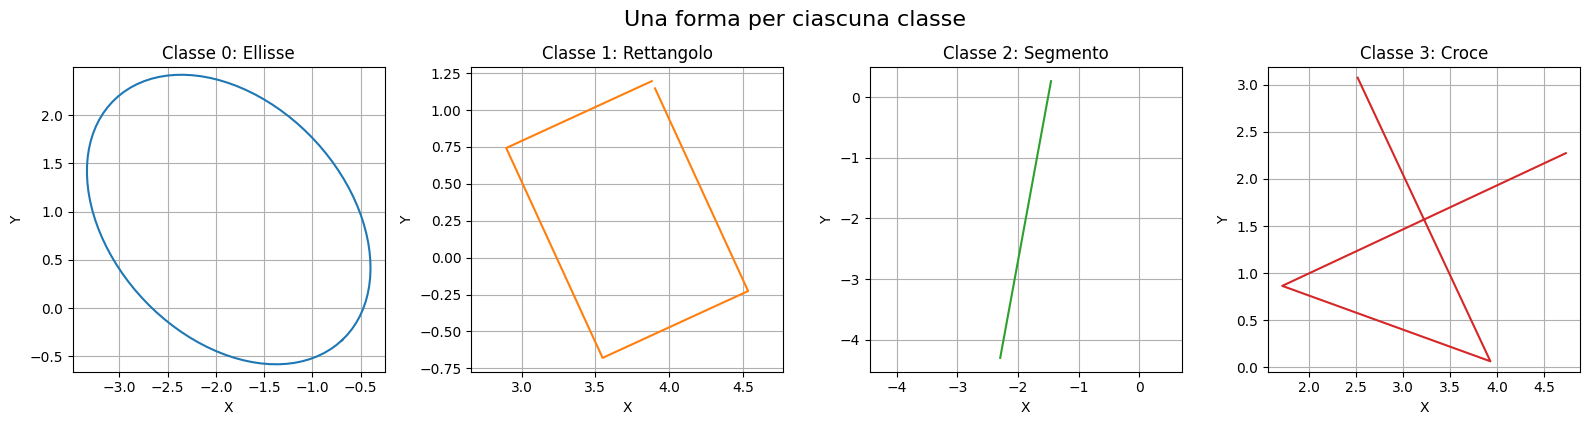

In [228]:
plot_shape(X, y, labels)

## Feature Selection

Definiamo una nuova rappresentazione per ciascuna forma, nel seguente modo: invece di usare gli $n$ punti generati, introduciamo $12$ features, ovvero:
- Area
- Area convessa
- Rapporto tra le aree
- Perimetro
- Distanze tra punti estremi
- Aspect ratio ed eccentricità
- media, deviazione standard, massimo e minimo della distanza dal centroide
- distanza massima tra punti

Di queste $12$ feature, andiamo a selezionare le più rilevanti facendo **feature selection**.

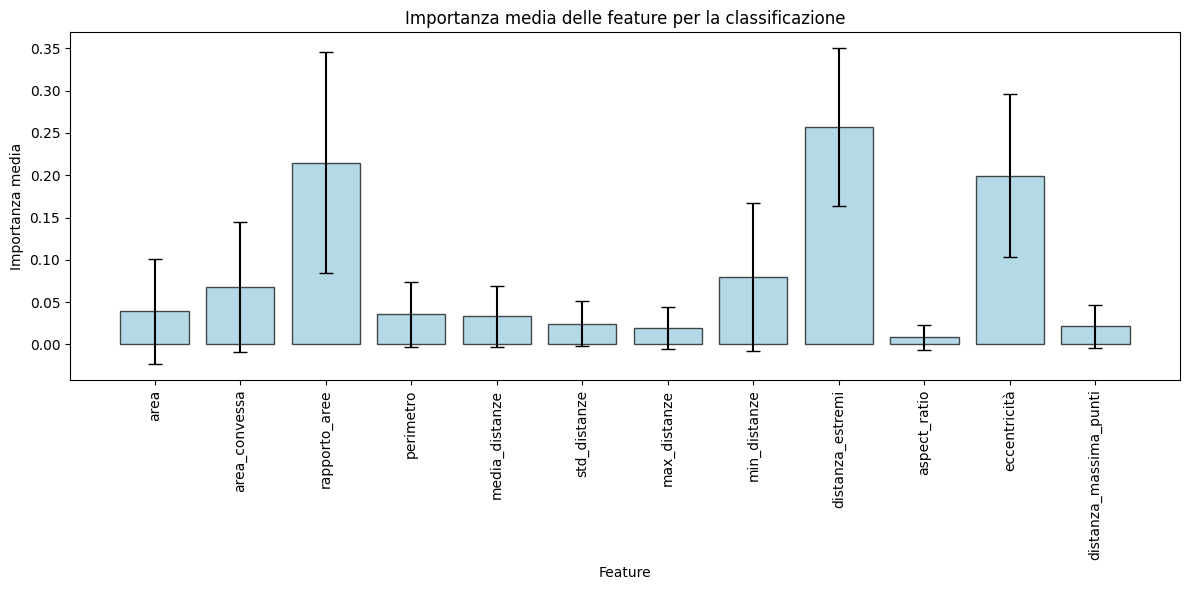

In [229]:

X_selection = ottieni_features(X) # solo 11 features, senza punti e distanze dal centroide

forest = ExtraTreesClassifier(n_estimators=250, random_state=0) # aggiunge più randomizzazione nella scelta della soglia
forest.fit(X_selection, y)

ff = np.array([tree.feature_importances_ for tree in forest.estimators_])

n_punti = X.shape[1]

feature_names = ['area', 'area_convessa', 'rapporto_aree', 'perimetro',
                  'media_distanze', 'std_distanze', 'max_distanze', 'min_distanze',
                  'distanza_estremi', 'aspect_ratio', 'eccentricità', 'distanza_massima_punti']

importanze_medie = ff.mean(axis=0)
importanze_std = ff.std(axis=0)

df_plot = pd.DataFrame({
    "feature": feature_names,
    "importanza": importanze_medie,
    "errore": importanze_std
})

plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x="feature", y="importanza", errorbar=None, alpha=0.7, color='skyblue', edgecolor='black')

plt.errorbar(x=range(len(feature_names)), y=importanze_medie, yerr=importanze_std, fmt='none', c='black', capsize=5)

plt.xticks(rotation=90)
plt.title('Importanza media delle feature per la classificazione')
plt.ylabel('Importanza media')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()


Adesso, una volta calcolata l'importanza di ciascuna feature, prendiamo quelle che ci offrono maggiori informazioni per l'addestramento. Come facciamo a capire quante feature prendere? Andiamo ad addestrare $d$ classificatori, dove $d$ è il numero di feature, e per ciascun classificatore ci calcoliamo l'acuratezza delle predizioni, e guardando poi il grafico, scegliamo il numero di feature da utilizzare.

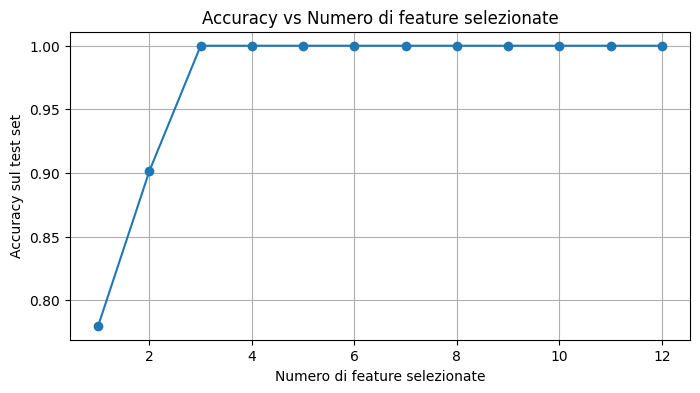

In [230]:
idx_sorted = np.argsort(importanze_medie)[::-1]  # indici delle feature ordinate per importanza decrescente

accuracies = []
feature_range = range(1, len(feature_names) + 1)
for k in feature_range:
    X_f_k = X_selection[:, idx_sorted[:k]]
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X_f_k, y, test_size=0.3, random_state=42, stratify=y)
    clf_k = RandomForestClassifier(random_state=42)
    clf_k.fit(X_train_k, y_train_k)
    y_pred_k = clf_k.predict(X_test_k)
    acc_k = accuracy_score(y_test_k, y_pred_k)
    accuracies.append(acc_k)

plt.figure(figsize=(8, 4))
plt.plot(feature_range, accuracies, marker='o')
plt.xlabel('Numero di feature selezionate')
plt.ylabel('Accuracy sul test set')
plt.title('Accuracy vs Numero di feature selezionate')
plt.grid(True)
plt.show()

In [231]:
def seleziona_feature_custom(X, idx_sorted, k):
    return X[:, idx_sorted[:k]]

In [232]:
top_k = 10
feature_selezionate = [feature_names[i] for i in idx_sorted[:top_k]]
print("Feature più importanti:", feature_selezionate)

X_f_selected = seleziona_feature_custom(X_selection, idx_sorted, top_k)

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(X_f_selected, y, test_size=0.3, random_state=42, stratify=y)

clf_sel = RandomForestClassifier(random_state=42)
clf_sel.fit(X_train_sel, y_train_sel)
y_pred_sel = clf_sel.predict(X_test_sel)
acc_sel = accuracy_score(y_test_sel, y_pred_sel)
print(f"Accuracy sul test set usando solo le {top_k} feature più importanti: {acc_sel:.4f}")

Feature più importanti: ['distanza_estremi', 'rapporto_aree', 'eccentricità', 'min_distanze', 'area_convessa', 'area', 'perimetro', 'media_distanze', 'std_distanze', 'distanza_massima_punti']
Accuracy sul test set usando solo le 10 feature più importanti: 1.0000


## Feature Extraction (PCA)

1. **Scelta delle componenti**

La prima fase di Feature Extraction consiste nell'applicare PCA sull'intero dataset e andare a misurare la quantità di varianza spiegata dalle componenti principali. 

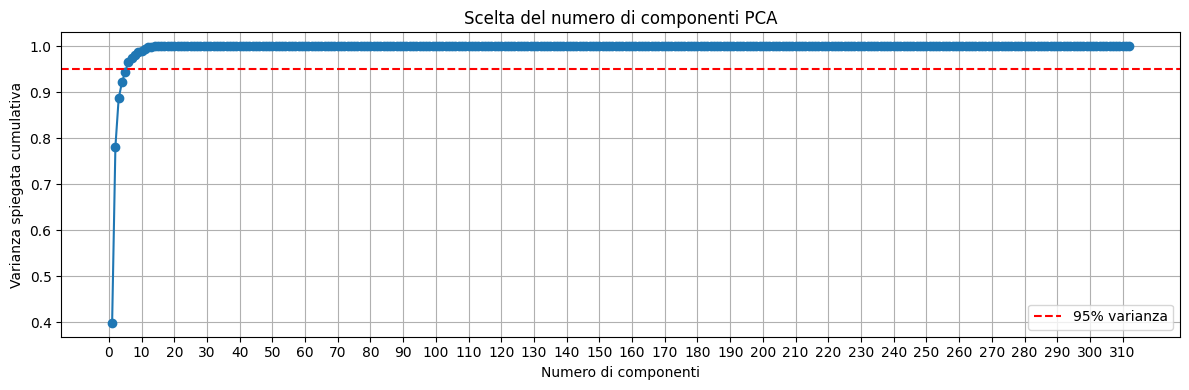

In [233]:
X_extraction = ottieni_features(X, distanze=True, points=True)

pca = PCA(svd_solver="randomized", whiten=True)
pca.fit(X_extraction)

# Varianza spiegata cumulativa
varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(varianza_cumulativa)+1), varianza_cumulativa, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza spiegata cumulativa")
plt.title("Scelta del numero di componenti PCA")
plt.grid(True)
plt.legend()
plt.xticks(ticks=np.arange(0, len(varianza_cumulativa) + 1, 10))
plt.tight_layout()
plt.show()

2. **Addestramente modello finale**

Osservando il grafico, quello che ci interessa è di scegliere il numero di componenti per cui la varianza si stabilizza. Utilizzeremo poi quel numero di componenti per addestrare il modello di vero di PCA da usare poi nelle fasi successive.

In [234]:
print("Shape di X_extraction:", X_extraction.shape)
print("Shape di y:", y.shape)

n_features = 20
pca = PCA(n_components=n_features, svd_solver="randomized", whiten=True).fit(X_extraction)
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X_extraction, y, test_size=0.3, random_state=42, stratify=y)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Shape pca_train:", X_train_pca.shape)
print("Shape pca_test:", X_test_pca.shape)
print("Shape y_train:", y_train_pca.shape)
print("Shape y_test:", y_test_pca.shape)

Shape di X_extraction: (4000, 312)
Shape di y: (4000,)
Shape pca_train: (2800, 20)
Shape pca_test: (1200, 20)
Shape y_train: (2800,)
Shape y_test: (1200,)


In [235]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_pca, y_train_pca)
y_pred = clf.predict(X_train_pca)
acc = accuracy_score(y_train_pca, y_pred)
print(f"Accuracy sul training set: {acc:.4f}")
y_pred = clf.predict(X_test_pca)
acc = accuracy_score(y_test_pca, y_pred)
print(f"Accuracy sul test set: {acc:.4f}")

Accuracy sul training set: 1.0000
Accuracy sul test set: 0.9983


# Model Selection

In questa fase andremo a testare vari modelli di classificatori, cercando il migliore. Andremo ad usare i seguenti modelli: `RandomForest`, `LinearRegressione` e `SVM`. Andremo a testare ciascun modello sia sul dataset ottenuto mediante feature selection che su quello ottenuto mediante PCA.

Effettuo Model Selection usando come datasets di train quelli ottenuti nella fase di feature selection e nella fase di feature extraction. Una volta finito l'addestramento, verifico il modello sul test set appropriato. Dovendo fare model selection su due dataset diversi, cerco il migliore estimatore per quanto riguarda feature selection, ed il miglior estimatore per quanto riguarda PCA.

In [236]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f-score': make_scorer(f1_score, average='macro', zero_division=0)
}

# Qui posso facilmente aggiungere ulteriori dataset, per esempio con tutti i punti e le distanze

X_train_sets = {"Feature Selection": X_train_sel, "PCA": X_train_pca}
y_train_sets = {"Feature Selection": y_train_sel, "PCA": y_train_pca}

X_test_sets = {"Feature Selection": X_test_sel, "PCA": X_test_pca}
y_test_sets = {"Feature Selection": y_test_sel, "PCA": y_test_pca}

In [237]:
y_train_sets

{'Feature Selection': array([0, 0, 0, ..., 1, 2, 0], shape=(2800,)),
 'PCA': array([0, 0, 0, ..., 1, 2, 0], shape=(2800,))}

## 1. RandomForest

In [238]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}

best_models_rf = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(
        rf, param_grid, cv=5, scoring=scoring, refit="accuracy", n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)

    best_models_rf[name] = grid.best_estimator_

for name in best_models_rf:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_rf[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))
        
# Modelli migliori: best_models_rf


Risultati per: Feature Selection
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F-score: 1.0000
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

Risultati per: PCA
Accuracy: 0.9996
Precision: 0.9996
Recall: 0.9996
F-score: 0.9996
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

Test set performance for: Feature Selection
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Test set performance for: PCA
Accuracy: 0.9983
              precision    recall  f1-score   support

           0

### Matrici di Confusione

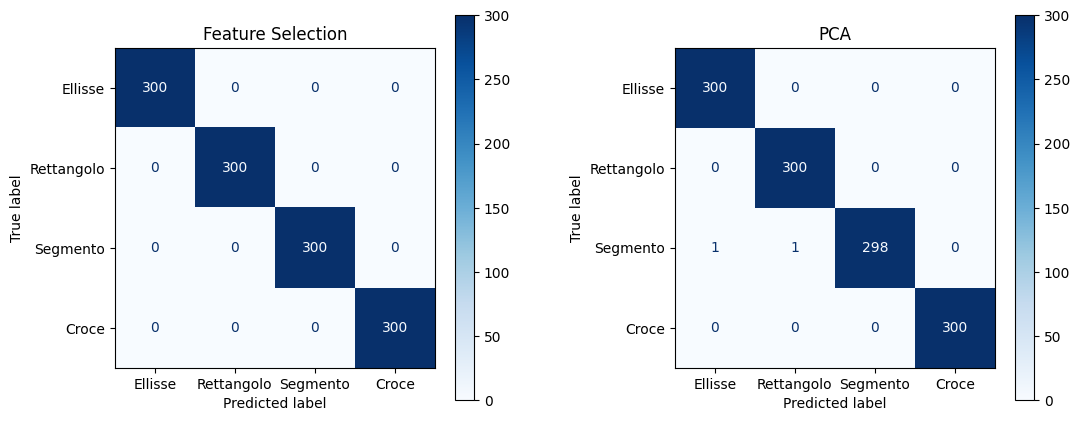

In [239]:
fig, axes = plt.subplots(1, len(best_models_rf), figsize=(12, 5))

for ax, name in zip(axes, best_models_rf):
    y_test_set = y_test_sets[name]
    y_pred = best_models_rf[name].predict(X_test_sets[name])
    
    ConfusionMatrixDisplay.from_predictions(
        y_test_set, y_pred,
        display_labels=[label.capitalize() for label in labels],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name}")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## 2. Logistic Regression

In [240]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  
    'logisticregression__penalty': ['l2'],             
    'logisticregression__solver': ['lbfgs'],           
    'logisticregression__max_iter': [1000, 2000, 5000],        
}

best_models_lrg = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]
    
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=42)
    )

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)
    
    best_models_lrg[name] = grid.best_estimator_

for name in best_models_lrg:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_lrg[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))

# Modelli migliori: best_models_lrg


Risultati per: Feature Selection
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-score: 0.9993
Best params: {'logisticregression__C': 100, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Risultati per: PCA
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F-score: 0.9989
Best params: {'logisticregression__C': 10, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Test set performance for: Feature Selection
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


T

### Matrici di Confusione

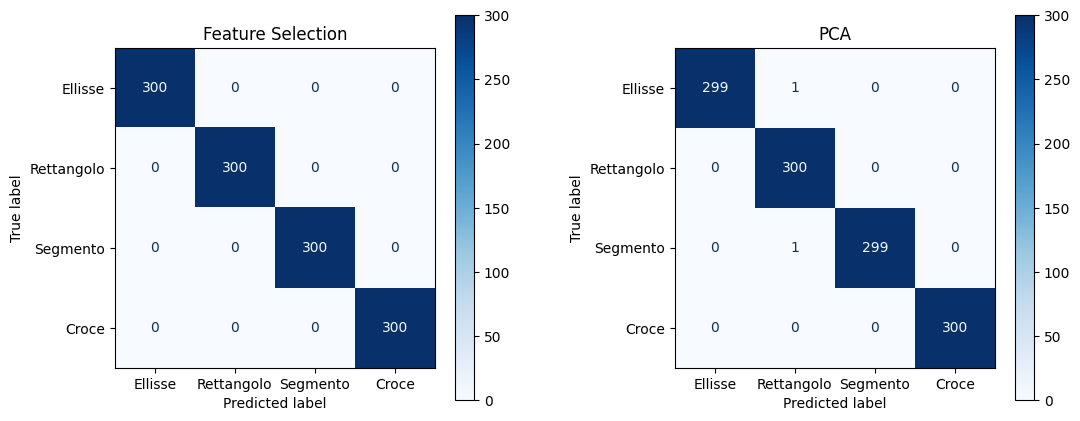

In [241]:
fig, axes = plt.subplots(1, len(best_models_lrg), figsize=(12, 5))

for ax, name in zip(axes, best_models_lrg):
    y_test_set = y_test_sets[name]
    y_pred = best_models_lrg[name].predict(X_test_sets[name])
    
    ConfusionMatrixDisplay.from_predictions(
        y_test_set, y_pred,
        display_labels=[label.capitalize() for label in labels],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name}")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## 3. SVM

In [242]:
param_grid = {
    'svc__kernel': ['linear', 'rbf'],
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 'auto']
}

best_models_svm = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]
    
    pipeline = make_pipeline(
        StandardScaler(),
        SVC(random_state=42)
    )
    
    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=1
    )
    
    grid.fit(X_train_set, y_train_set)
    
    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)
    
    best_models_svm[name] = grid.best_estimator_

for name in best_models_svm:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_svm[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))


Risultati per: Feature Selection
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-score: 0.9993
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}

Risultati per: PCA
Accuracy: 0.9993
Precision: 0.9993
Recall: 0.9993
F-score: 0.9993
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}

Test set performance for: Feature Selection
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       300
           1       1.00      1.00      1.00       300
           2       1.00      1.00      1.00       300
           3       1.00      1.00      1.00       300

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200


Test set performance for: PCA
Accuracy: 0.9975
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       300
           1

### Matrici di Confusione

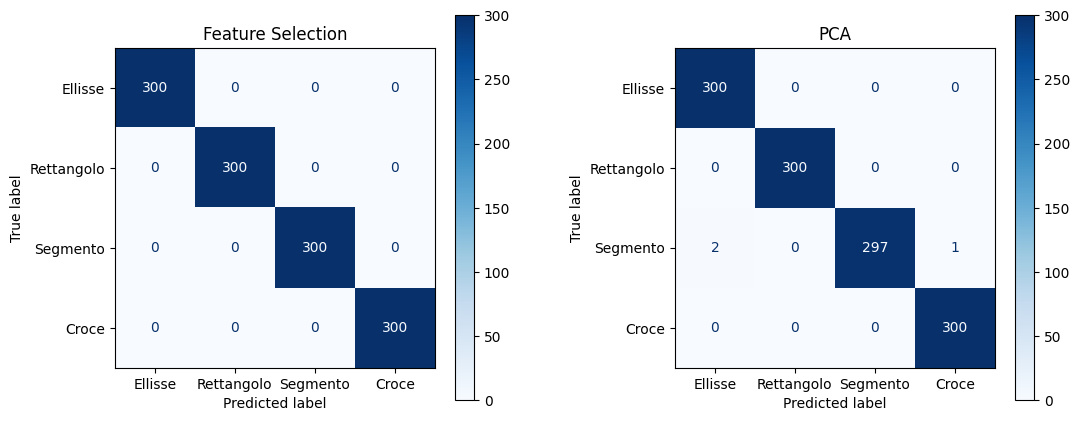

In [243]:
fig, axes = plt.subplots(1, len(best_models_svm), figsize=(12, 5))

for ax, name in zip(axes, best_models_svm):
    y_test_set = y_test_sets[name]
    y_pred = best_models_svm[name].predict(X_test_sets[name])
    
    ConfusionMatrixDisplay.from_predictions(
        y_test_set, y_pred,
        display_labels=[label.capitalize() for label in labels],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name}")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

## Test di Robustezza

In [244]:
punti_fisso = 100
forme_fisso = 2000
rumore_fisso = 0.9

# Configurazioni da testare
punti = [50, 100, 150, 200, 250]
forme = [1000, 1500, 2000, 2500, 3000, 3500]
rumore = [0, 0.1, 0.3, 0.6, 0.8]

datasets_variati = {
    "punti": {(forme_fisso, p, rumore_fisso): genera_campioni(forme_fisso, p, rumore_fisso) for p in punti},
    "forme": {(f, punti_fisso, rumore_fisso): genera_campioni(f, punti_fisso, rumore_fisso) for f in forme},
    "rumore": {(forme_fisso, punti_fisso, r): genera_campioni(forme_fisso, punti_fisso, r) for r in rumore}
}

In [245]:
print("[INFO]: PUNTI      - ", datasets_variati["punti"].keys())
print("[INFO]: FORME    - ", datasets_variati["forme"].keys())
print("[INFO]: RUMORE - ", datasets_variati["rumore"].keys())

[INFO]: PUNTI      -  dict_keys([(2000, 50, 0.9), (2000, 100, 0.9), (2000, 150, 0.9), (2000, 200, 0.9), (2000, 250, 0.9)])
[INFO]: FORME    -  dict_keys([(1000, 100, 0.9), (1500, 100, 0.9), (2000, 100, 0.9), (2500, 100, 0.9), (3000, 100, 0.9), (3500, 100, 0.9)])
[INFO]: RUMORE -  dict_keys([(2000, 100, 0), (2000, 100, 0.1), (2000, 100, 0.3), (2000, 100, 0.6), (2000, 100, 0.8)])


In [246]:
def valuta_modello(modello, X, y_true, ndigits=4):
    y_pred = modello.predict(X)
    return {
        "accuracy": round(accuracy_score(y_true, y_pred), ndigits),
        "precision": round(
            precision_score(y_true, y_pred, average="macro", zero_division=0), ndigits
        ),
        "recall": round(recall_score(y_true, y_pred, average="macro", zero_division=0), ndigits),
        "f1": round(f1_score(y_true, y_pred, average="macro", zero_division=0), ndigits),
    }


def feature_selection_test(model, parametri, nome, X, y):
    X_sel = ottieni_features(X)
    X_sel = seleziona_feature_custom(X_sel, idx_sorted, top_k)

    X_train, X_test, y_train, y_test = train_test_split(
        X_sel, y, test_size=0.3, random_state=42, stratify=y
    )

    model.fit(X_train, y_train)

    risultati = valuta_modello(model, X_test, y_test)
    risultati["parametri"] = {
        "tipo": nome,
        "forme": parametri[0],
        "punti": parametri[1],
        "rumore": parametri[2],
    }

    return risultati


def pca_test(model, parametri, nome, n_components, X, y):
    X_pca = ottieni_features(X, distanze=True, points=True)

    X_train, X_test, y_train_pca, y_test_pca = train_test_split(
        X_pca, y, test_size=0.3, random_state=42, stratify=y
    )

    pca = PCA(n_components=n_components, svd_solver="randomized", whiten=True)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    model.fit(X_train_pca, y_train_pca)

    risultati = valuta_modello(model, X_test_pca, y_test_pca)
    risultati["parametri"] = {
        "tipo": nome,
        "forme": parametri[0],
        "punti": parametri[1],
        "rumore": parametri[2],
    }

    return risultati


def test_robustezza_random_forest():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():  # parametri = (forme, punti, rumore)
            # FEATURE SELECTION

            parametri_modello = best_models_rf["Feature Selection"].get_params()
            parametri_modello["n_jobs"] = -1  # uso tutti i core a disposizione
            new_model_selection = RandomForestClassifier(**parametri_modello)

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = best_models_rf["PCA"].get_params()
            parametri_modello["n_jobs"] = -1  # uso tutti i core a disposizione
            new_model_pca = RandomForestClassifier(**parametri_modello)

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def test_robustezza_logistic_regression():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("logisticregression__")
            }
            parametri_modello["n_jobs"] = -1
            new_model_selection = make_pipeline(
                StandardScaler(), LogisticRegression(**parametri_modello)
            )

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("logisticregression__")
            }
            parametri_modello["n_jobs"] = -1
            new_model_pca = make_pipeline(StandardScaler(), LogisticRegression(**parametri_modello))

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def test_robustezza_svm():
    results_selection = {}
    results_pca = {}

    for nome, tipo_dataset in datasets_variati.items():
        for parametri, (X, y) in tipo_dataset.items():

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("svc__")
            }
            new_model_selection = make_pipeline(StandardScaler(), SVC(**parametri_modello))

            risultati_sel = feature_selection_test(new_model_selection, parametri, nome, X=X, y=y)

            results_selection.setdefault(nome, []).append(risultati_sel)

            # FEATURE EXTRACTION CON PCA

            parametri_modello = {
                k.split("__")[1]: v
                for k, v in best_models_lrg["Feature Selection"].get_params().items()
                if k.startswith("svc__")
            }
            new_model_pca = make_pipeline(StandardScaler(), SVC(**parametri_modello))

            risultati_pca = pca_test(new_model_pca, parametri, nome, n_components=10, X=X, y=y)

            results_pca.setdefault(nome, []).append(risultati_pca)

    return results_selection, results_pca


def print_risultati(results_sel, results_pca):
    print("[INFO]: Risultati modello feature selection:\n")

    for keys, values in results_sel.items():
        print("Tipo di dataset:", keys)
        for val in values:
            print(val["accuracy"], val["parametri"])

    print("\n[INFO]: Risultati modello PCA:\n")
    for keys, values in results_pca.items():
        print("Tipo di dataset:", keys)
        for val in values:
            print(val["accuracy"], val["parametri"])


def plot_test_results(variazione, results, title, ax=None):
    """
    Plotta l'andamento di più metriche (accuracy, precision, recall, f1)
    al variare di un parametro del dataset.

    Args:
        variazione (str): Nome del parametro variato ("punti", "forme", "rumore").
        results (dict): Dizionario dei risultati, con chiave uguale a variazione.
        titolo_modello (str): Titolo aggiuntivo per il grafico.
        ax (matplotlib.axes._subplots.AxesSubplot): Asse su cui disegnare il grafico (opzionale).
    """
    risultati = results[variazione]
    valori_x = [res["parametri"][variazione] for res in risultati]

    # Estrazione delle metriche
    metriche = {
        "Accuracy": [res["accuracy"] for res in risultati],
        "Precision": [res["precision"] for res in risultati],
    }

    if ax is None:
        fig, ax = plt.subplots()

    # Tracciamento di ciascuna metrica
    for nome_metrica, valori_y in metriche.items():
        ax.plot(valori_x, valori_y, marker="o", linestyle="-", label=nome_metrica)

    # Etichette asse X
    if variazione == "rumore":
        ax.set_xlabel("Livello di rumore")
    elif variazione == "punti":
        ax.set_xlabel("Numero di punti per forma")
    elif variazione == "forme":
        ax.set_xlabel("Numero di forme")
    else:
        ax.set_xlabel(variazione.capitalize())

    # Etichette e titolo
    ax.set_ylabel("Valore metrica")
    ax.set_title(f"Andamento metriche vs {variazione.capitalize()} ({title})")
    ax.grid(True)
    ax.legend()

def plot_figure(results, title):
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, var in enumerate(["punti", "forme", "rumore"]):
        plot_test_results(var, results=results, ax=axs[i], title=title)

    plt.tight_layout()
    plt.show()

### Risultati

In [247]:
results_selection_rf, results_pca_rf = test_robustezza_random_forest()

In [248]:
print_risultati(results_sel=results_selection_rf, results_pca=results_pca_rf)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.7504 {'tipo': 'punti', 'forme': 2000, 'punti': 50, 'rumore': 0.9}
0.7483 {'tipo': 'punti', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.7417 {'tipo': 'punti', 'forme': 2000, 'punti': 150, 'rumore': 0.9}
0.7483 {'tipo': 'punti', 'forme': 2000, 'punti': 200, 'rumore': 0.9}
0.7579 {'tipo': 'punti', 'forme': 2000, 'punti': 250, 'rumore': 0.9}
Tipo di dataset: forme
0.7342 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.9}
0.7394 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.9}
0.75 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.753 {'tipo': 'forme', 'forme': 2500, 'punti': 100, 'rumore': 0.9}
0.7636 {'tipo': 'forme', 'forme': 3000, 'punti': 100, 'rumore': 0.9}
0.7629 {'tipo': 'forme', 'forme': 3500, 'punti': 100, 'rumore': 0.9}
Tipo di dataset: rumore
1.0 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'rumore': 0}
0.9375 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'rumore':

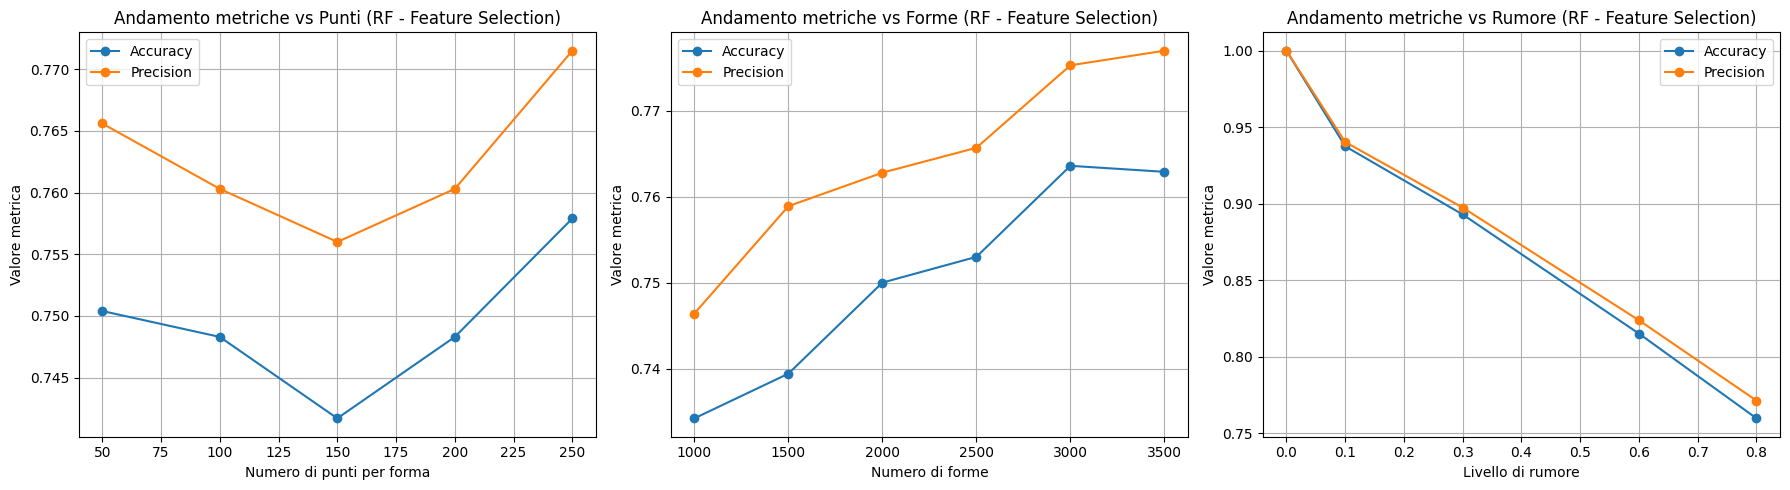

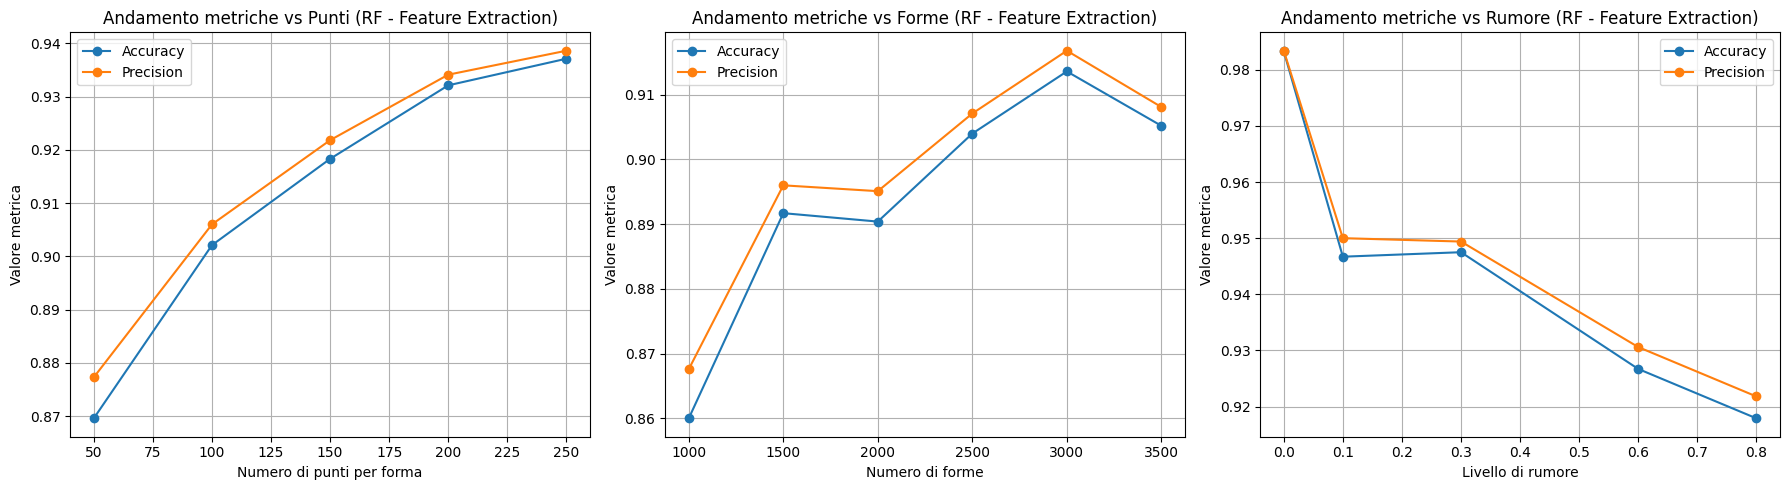

In [249]:
plot_figure(results=results_selection_rf, title="RF - Feature Selection")
plot_figure(results=results_pca_rf, title="RF - Feature Extraction")

In [250]:
results_selection_lrg, results_pca_lrg = test_robustezza_logistic_regression()

In [251]:
print_risultati(results_sel=results_selection_lrg, results_pca=results_pca_lrg)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.7367 {'tipo': 'punti', 'forme': 2000, 'punti': 50, 'rumore': 0.9}
0.7262 {'tipo': 'punti', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.7275 {'tipo': 'punti', 'forme': 2000, 'punti': 150, 'rumore': 0.9}
0.7383 {'tipo': 'punti', 'forme': 2000, 'punti': 200, 'rumore': 0.9}
0.7562 {'tipo': 'punti', 'forme': 2000, 'punti': 250, 'rumore': 0.9}
Tipo di dataset: forme
0.7308 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.9}
0.7344 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.9}
0.7192 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.7337 {'tipo': 'forme', 'forme': 2500, 'punti': 100, 'rumore': 0.9}
0.75 {'tipo': 'forme', 'forme': 3000, 'punti': 100, 'rumore': 0.9}
0.736 {'tipo': 'forme', 'forme': 3500, 'punti': 100, 'rumore': 0.9}
Tipo di dataset: rumore
0.9996 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'rumore': 0}
0.8942 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'rumor

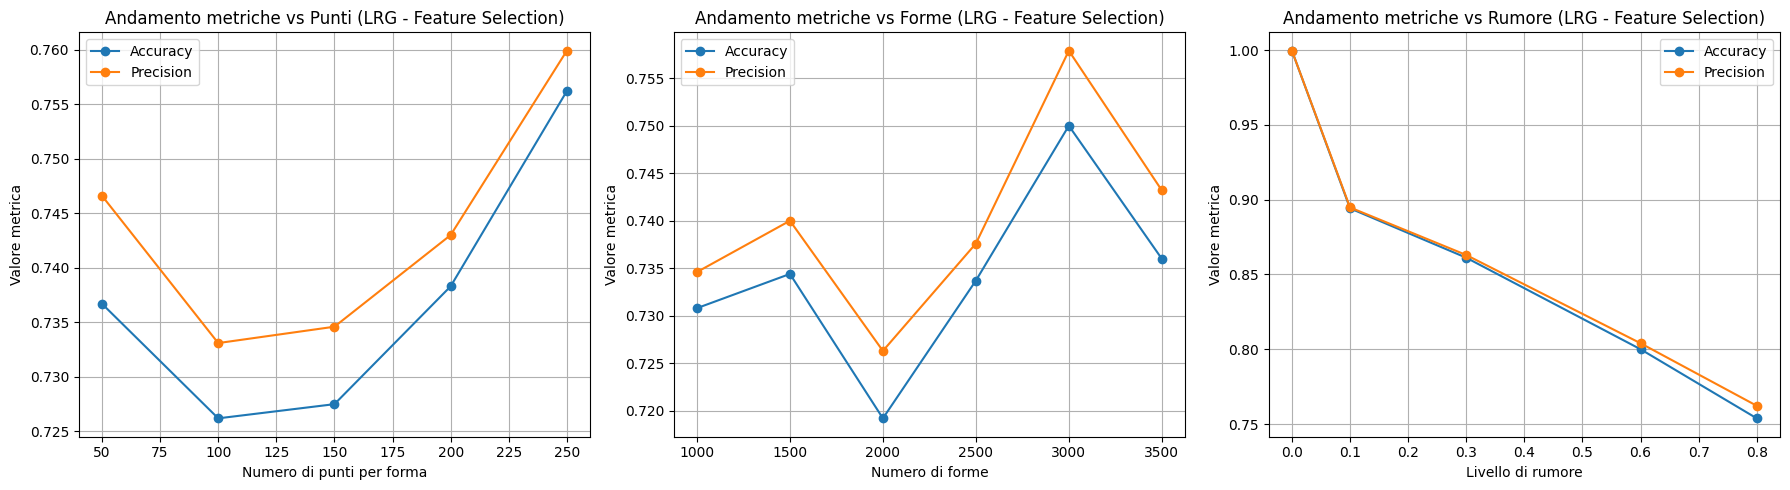

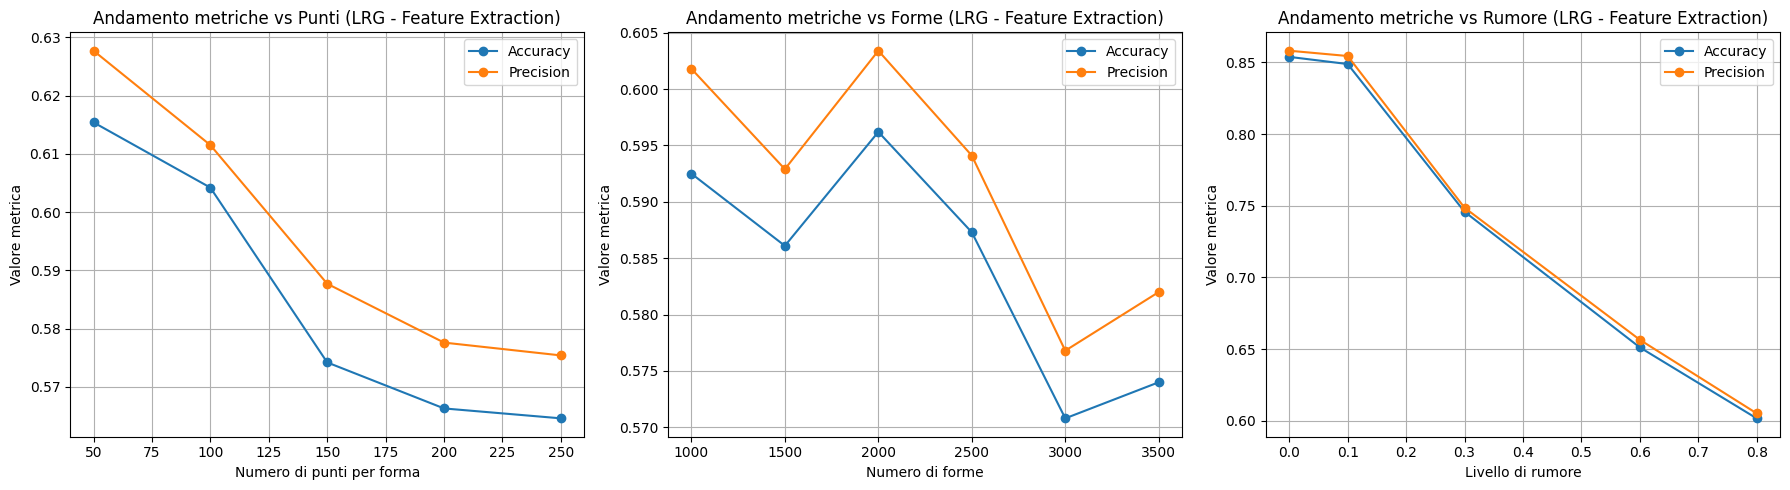

In [252]:
plot_figure(results=results_selection_lrg, title="LRG - Feature Selection")
plot_figure(results=results_pca_lrg, title="LRG - Feature Extraction")

In [253]:
results_selection_svm, results_pca_svm = test_robustezza_svm()

In [254]:
print_risultati(results_sel=results_selection_svm, results_pca=results_pca_svm)

[INFO]: Risultati modello feature selection:

Tipo di dataset: punti
0.7662 {'tipo': 'punti', 'forme': 2000, 'punti': 50, 'rumore': 0.9}
0.7646 {'tipo': 'punti', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.7621 {'tipo': 'punti', 'forme': 2000, 'punti': 150, 'rumore': 0.9}
0.7596 {'tipo': 'punti', 'forme': 2000, 'punti': 200, 'rumore': 0.9}
0.7796 {'tipo': 'punti', 'forme': 2000, 'punti': 250, 'rumore': 0.9}
Tipo di dataset: forme
0.7425 {'tipo': 'forme', 'forme': 1000, 'punti': 100, 'rumore': 0.9}
0.7606 {'tipo': 'forme', 'forme': 1500, 'punti': 100, 'rumore': 0.9}
0.7608 {'tipo': 'forme', 'forme': 2000, 'punti': 100, 'rumore': 0.9}
0.7717 {'tipo': 'forme', 'forme': 2500, 'punti': 100, 'rumore': 0.9}
0.7797 {'tipo': 'forme', 'forme': 3000, 'punti': 100, 'rumore': 0.9}
0.7733 {'tipo': 'forme', 'forme': 3500, 'punti': 100, 'rumore': 0.9}
Tipo di dataset: rumore
0.9875 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'rumore': 0}
0.9287 {'tipo': 'rumore', 'forme': 2000, 'punti': 100, 'ru

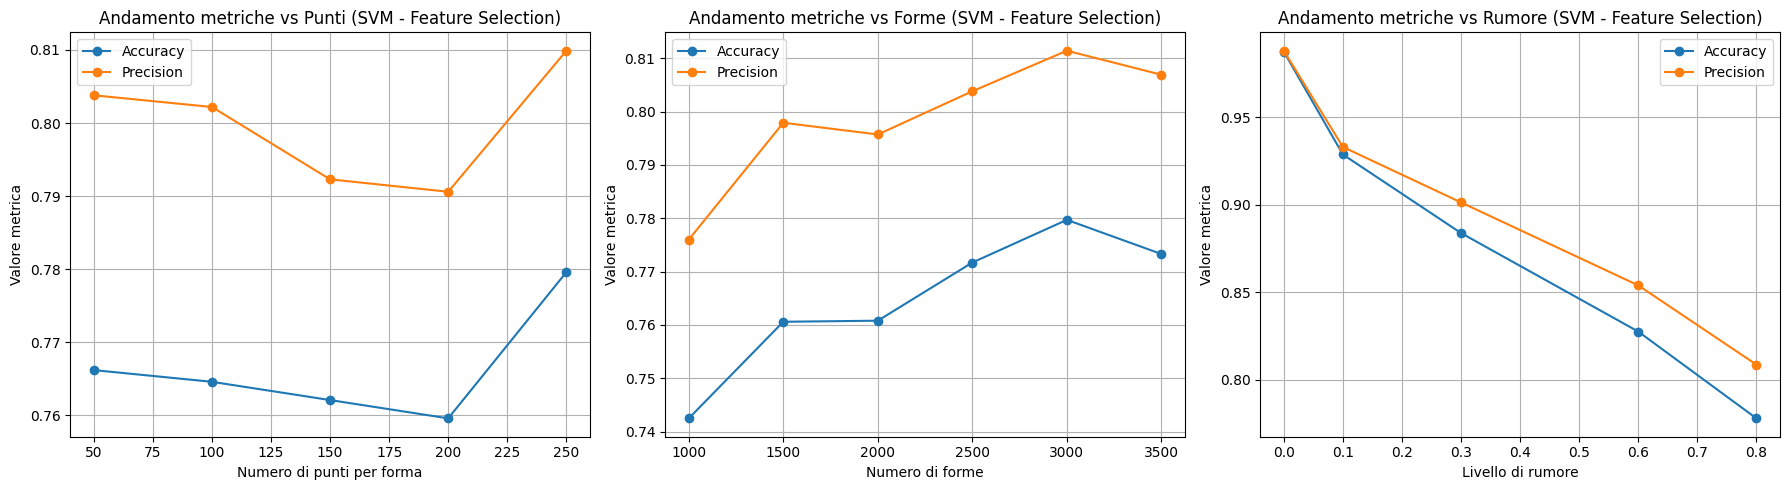

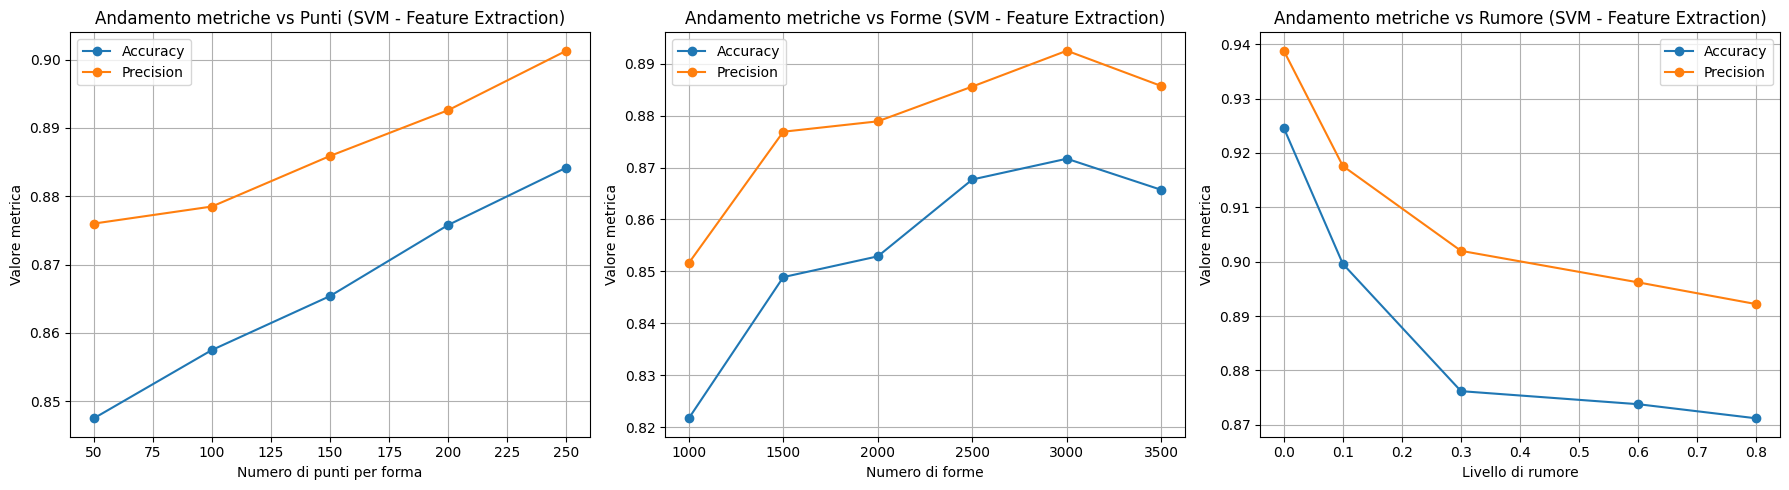

In [255]:
plot_figure(results=results_selection_svm, title="SVM - Feature Selection")
plot_figure(results=results_pca_svm, title="SVM - Feature Extraction")

## Classificazione Binaria

In [265]:
labels = ["AreaPositiva", "AreaNulla"]

X, y = genera_campioni(n_shapes=1000, n_punti=100, rumore_std_bound=0.5)

# Unisce le classi: 0 (ellisse) e 1 (rettangolo) -> 0 (AreaPositiva), 2 (segmento) e 3 (croce) -> 1 (AreaNulla)
y = np.where(y < 2, 0, 1)

### Feature Selection

[INFO]: Accuratezza prima della feature selection:  0.9708333333333333


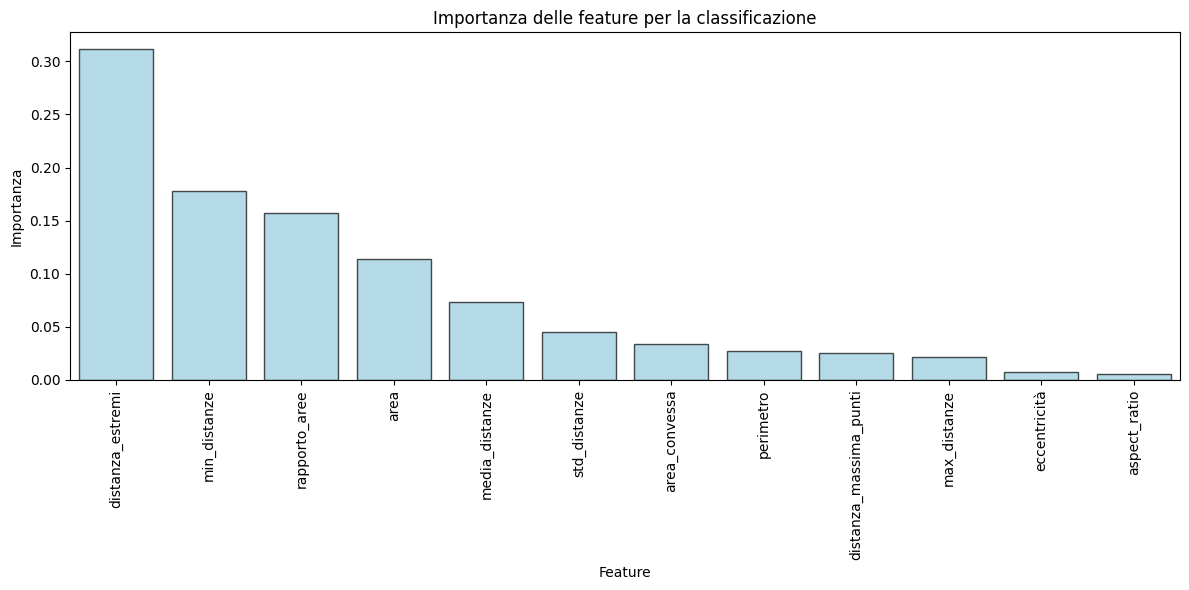

In [257]:
X_f = ottieni_features(X)
X_train, X_test, y_train_sel, y_test_sel = train_test_split(X_f, y, test_size=0.3, random_state=42, stratify=y)

# Allenamento del classificatore
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train_sel)

# Importanza delle feature
importanze = clf.feature_importances_

# Predizione e accuratezza
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test_sel, y_pred)

print("[INFO]: Accuratezza prima della feature selection: ", accuracy)

# Nomi delle feature
feature_names = ['area', 'area_convessa', 'rapporto_aree', 'perimetro',
                 'media_distanze', 'std_distanze', 'max_distanze', 'min_distanze',
                 'distanza_estremi', 'aspect_ratio', 'eccentricità', 'distanza_massima_punti']

# Creazione DataFrame per visualizzazione
df_plot = pd.DataFrame({
    "feature": feature_names,
    "importanza": importanze
})

# Ordinamento opzionale per visualizzazione più chiara
df_plot = df_plot.sort_values(by="importanza", ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_plot, x="feature", y="importanza", alpha=0.7, color='skyblue', edgecolor='black')
plt.xticks(rotation=90)
plt.title('Importanza delle feature per la classificazione')
plt.ylabel('Importanza')
plt.xlabel('Feature')
plt.tight_layout()
plt.show()

In [258]:
# Selezioniamo le feature più importnanti
selector = SelectFromModel(clf, prefit=True, threshold='median')
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

clf_selected = RandomForestClassifier(random_state=42)
clf_selected.fit(X_train_sel, y_train_sel)

y_pred_selected = clf_selected.predict(X_test_sel)
accuracy_selected = accuracy_score(y_test_sel, y_pred_selected)

print(f"[INFO]: Accuratezza dopo della feature selection: {accuracy_selected:.4f}")

[INFO]: Accuratezza dopo della feature selection: 0.9683


### Feature Extraction

1. **Scelta delle componenti**

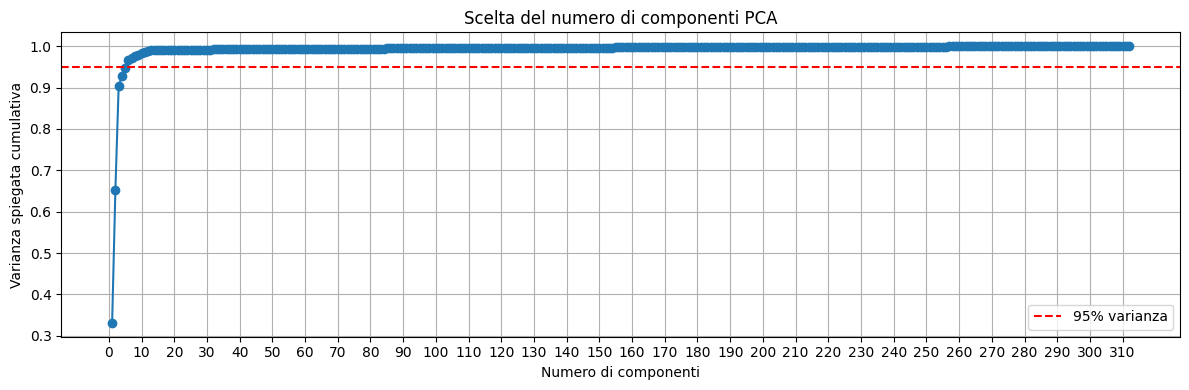

In [259]:
X_extraction = ottieni_features(X, distanze=True, points=True)

pca = PCA(svd_solver="randomized", whiten=True)
pca.fit(X_extraction)

# Varianza spiegata cumulativa
varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 4))
plt.plot(range(1, len(varianza_cumulativa)+1), varianza_cumulativa, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varianza')
plt.xlabel("Numero di componenti")
plt.ylabel("Varianza spiegata cumulativa")
plt.title("Scelta del numero di componenti PCA")
plt.grid(True)
plt.legend()
plt.xticks(ticks=np.arange(0, len(varianza_cumulativa) + 1, 10))
plt.tight_layout()
plt.show()

2. **Addestramento modello finale**

In [268]:
X_train, X_test, y_train_pca, y_test_pca = train_test_split(X_extraction, y, test_size=0.3, random_state=42, stratify=y)

n_features = 12

pca = PCA(n_components=n_features, svd_solver="randomized", whiten=True)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Classificatore
clf_pca = RandomForestClassifier(random_state=42)
clf_pca.fit(X_train_pca, y_train_pca)

# Valutazione
y_pred_pca = clf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)

print(f"[INFO]: Accuratezza dopo PCA: {accuracy_pca:.4f}")
print(f"[INFO]: Numero componenti selezionate: {pca.n_components_}")

[INFO]: Accuratezza dopo PCA: 0.9967
[INFO]: Numero componenti selezionate: 12


### Model Selection - RandomForest 

In [269]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='macro', zero_division=0),
    'recall': make_scorer(recall_score, average='macro', zero_division=0),
    'f-score': make_scorer(f1_score, average='macro', zero_division=0)
}

# Qui posso facilmente aggiungere ulteriori dataset, per esempio con tutti i punti e le distanze

X_train_sets = {"Feature Selection": X_train_sel, "PCA": X_train_pca}
y_train_sets = {"Feature Selection": y_train_sel, "PCA": y_train_pca}

X_test_sets = {"Feature Selection": X_test_sel, "PCA": X_test_pca}
y_test_sets = {"Feature Selection": y_test_sel, "PCA": y_test_pca}

In [275]:
y_test_sets

{'Feature Selection': array([0, 1, 1, ..., 0, 1, 1], shape=(1200,)),
 'PCA': array([0, 1, 1, ..., 0, 1, 1], shape=(1200,))}

In [278]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
}

best_models_rf = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]

    rf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(
        rf, param_grid, cv=5, scoring=scoring, refit="accuracy", n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)

    best_models_rf[name] = grid.best_estimator_

for name in best_models_rf:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_rf[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))
        
# Modelli migliori: best_models_rf


Risultati per: Feature Selection
Accuracy: 0.9732
Precision: 0.9732
Recall: 0.9732
F-score: 0.9732
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}

Risultati per: PCA
Accuracy: 0.9964
Precision: 0.9964
Recall: 0.9964
F-score: 0.9964
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 100}

Test set performance for: Feature Selection
Accuracy: 0.9675
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       600
           1       0.97      0.96      0.97       600

    accuracy                           0.97      1200
   macro avg       0.97      0.97      0.97      1200
weighted avg       0.97      0.97      0.97      1200


Test set performance for: PCA
Accuracy: 0.9958
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       600
           1       0.99      1.00      1.00       600

    accura

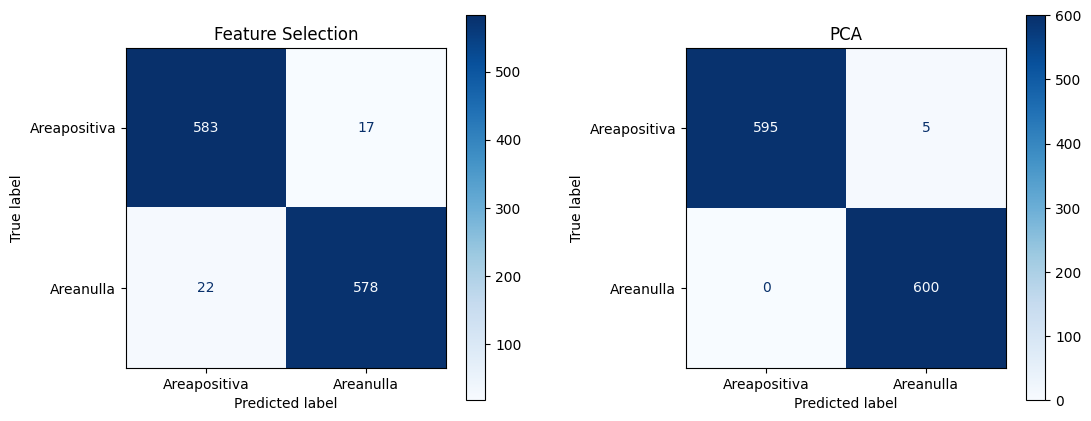

In [279]:
fig, axes = plt.subplots(1, len(best_models_rf), figsize=(12, 5))

for ax, name in zip(axes, best_models_rf):
    y_test_set = y_test_sets[name]
    y_pred = best_models_rf[name].predict(X_test_sets[name])
    ConfusionMatrixDisplay.from_predictions(
        y_test_set, y_pred,
        display_labels=[label.capitalize() for label in labels],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name}")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()

### Model Selection - Logistic Regression

In [280]:
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  
    'logisticregression__penalty': ['l2'],             
    'logisticregression__solver': ['lbfgs'],           
    'logisticregression__max_iter': [1000, 2000, 5000]             
}

best_models_lrg = {}

for name, X_train_set in X_train_sets.items():
    y_train_set = y_train_sets[name]
    
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression(random_state=42)
    )

    grid = GridSearchCV(
        pipeline,
        param_grid,
        cv=5,
        scoring=scoring,
        refit='accuracy',
        n_jobs=-1
    )
    grid.fit(X_train_set, y_train_set)

    print(f"\nRisultati per: {name}")
    for metric in scoring.keys():
        mean = grid.cv_results_[f"mean_test_{metric}"][grid.best_index_]
        print(f"{metric.capitalize()}: {mean:.4f}")
    print("Best params:", grid.best_params_)
    
    best_models_lrg[name] = grid.best_estimator_

for name in best_models_lrg:
    y_test_set = y_test_sets[name]
    print(f"\nTest set performance for: {name}")
    y_pred = best_models_lrg[name].predict(X_test_sets[name])
    print(f"Accuracy: {accuracy_score(y_test_set, y_pred):.4f}")
    print(classification_report(y_test_set, y_pred, zero_division=0))

# Modelli migliori: best_models_lrg


Risultati per: Feature Selection
Accuracy: 0.9786
Precision: 0.9787
Recall: 0.9786
F-score: 0.9786
Best params: {'logisticregression__C': 100, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Risultati per: PCA
Accuracy: 0.9475
Precision: 0.9478
Recall: 0.9475
F-score: 0.9475
Best params: {'logisticregression__C': 10, 'logisticregression__max_iter': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs'}

Test set performance for: Feature Selection
Accuracy: 0.9783
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       600
           1       0.98      0.98      0.98       600

    accuracy                           0.98      1200
   macro avg       0.98      0.98      0.98      1200
weighted avg       0.98      0.98      0.98      1200


Test set performance for: PCA
Accuracy: 0.9408
              precision    recall  f1-score   support

       

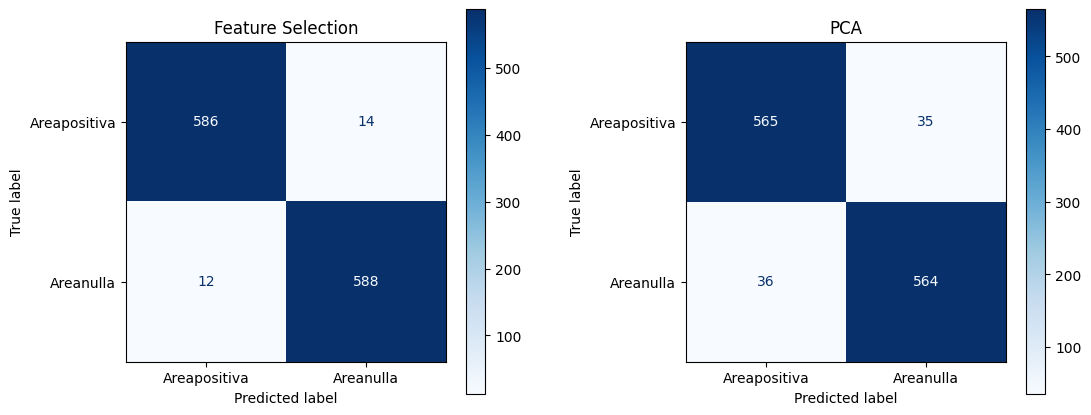

Exception ignored in: <function ResourceTracker.__del__ at 0x7f9b5fc84040>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fd140290040>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f5718d90040>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip

In [ ]:
fig, axes = plt.subplots(1, len(best_models_lrg), figsize=(12, 5))

for ax, name in zip(axes, best_models_lrg):
    y_test_set = y_test_sets[name]
    y_pred = best_models_lrg[name].predict(X_test_sets[name])
    ConfusionMatrixDisplay.from_predictions(
        y_test_set, y_pred,
        display_labels=[label.capitalize() for label in labels],
        cmap="Blues",
        ax=ax
    )
    ax.set_title(f"{name}")

plt.subplots_adjust(wspace=0.4, left=0.1, right=0.9)
plt.show()